In [13]:
pip install tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/1f/97/dec9dfa95cfbee631adffbeb0b7eda51ddc93a5f7e8aa8f4d95dde59e69e/tensorflow-2.16.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.16.2 from https://files.pythonhosted.org/packages/46/87/c3e4e9fe7c630f38a6984afdd1d4ed531ef9c74dc66b86f46f6bdd89d608/tensorflow_intel-2.16.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2d

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import shapiro
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

from scipy import stats

import joblib

In [2]:
#Loading the dataset

data = pd.read_csv("CO2_emission.csv")
#Reading the dataset
print(data.head())
print(data.info())

# Renaming columns
data.columns = [
    'Model_Year',
    'Make',
    'Model',
    'Vehicle_Class',
    'Engine_Size',
    'Cylinders',
    'Transmission',
    'Fuel_Consumption_City',
    'Fuel_Consumption_Hwy',
    'Fuel_Consumption_Comb',
    'CO2_Emissions',
    'Smog_Level'
]

   Model_Year   Make              Model Vehicle_Class  Engine_Size  Cylinders  \
0        2021  Acura                ILX       Compact          2.4          4   
1        2021  Acura                NSX    Two-seater          3.5          6   
2        2021  Acura         RDX SH-AWD    SUV: Small          2.0          4   
3        2021  Acura  RDX SH-AWD A-SPEC    SUV: Small          2.0          4   
4        2021  Acura         TLX SH-AWD       Compact          2.0          4   

  Transmission  Fuel_Consumption_in_City(L/100 km)  \
0          AM8                                 9.9   
1          AM9                                11.1   
2         AS10                                11.0   
3         AS10                                11.3   
4         AS10                                11.2   

   Fuel_Consumption_in_City_Hwy(L/100 km)  Fuel_Consumption_comb(L/100km)  \
0                                     7.0                             8.6   
1                                 

In [3]:
#Data Dimension
data_dimension = data.shape
print("Data Dimension:", data_dimension)

#Data Types
data_types = data.dtypes
print("\nData Types:\n", data_types)

#Missing Values
missing_values = data.isnull().sum()
print("\nMissing Values:\n", missing_values)

#Duplicate Data
duplicate_data = data.duplicated().sum()
print("\nDuplicate Rows:", duplicate_data)

#There are no missing values or duplicate data in the dataset

Data Dimension: (935, 12)

Data Types:
 Model_Year                 int64
Make                      object
Model                     object
Vehicle_Class             object
Engine_Size              float64
Cylinders                  int64
Transmission              object
Fuel_Consumption_City    float64
Fuel_Consumption_Hwy     float64
Fuel_Consumption_Comb    float64
CO2_Emissions              int64
Smog_Level                 int64
dtype: object

Missing Values:
 Model_Year               0
Make                     0
Model                    0
Vehicle_Class            0
Engine_Size              0
Cylinders                0
Transmission             0
Fuel_Consumption_City    0
Fuel_Consumption_Hwy     0
Fuel_Consumption_Comb    0
CO2_Emissions            0
Smog_Level               0
dtype: int64

Duplicate Rows: 0


In [4]:
# Summary statistics for numeric columns
numeric_summary = data.describe()

print("Numeric Summary Statistics:\n", numeric_summary)

average_co2_emissions = numeric_summary.loc['mean', 'CO2_Emissions']
average_fuel_city = numeric_summary.loc['mean', 'Fuel_Consumption_City']
average_fuel_hwy = numeric_summary.loc['mean', 'Fuel_Consumption_Hwy']
average_smog_level = numeric_summary.loc['mean', 'Smog_Level']

print(f"The average amount of CO2 emitted from cars is {average_co2_emissions:.2f} g/km.")
print(f"The average fuel consumption by cars in the city is {average_fuel_city:.2f} L/100 km.")
print(f"The average fuel consumption by cars on highways is {average_fuel_hwy:.2f} L/100 km.")
print(f"The average smog level rating of cars is {average_smog_level:.2f}.")


Numeric Summary Statistics:
        Model_Year  Engine_Size   Cylinders  Fuel_Consumption_City  \
count       935.0   935.000000  935.000000             935.000000   
mean       2021.0     3.214866    5.716578              12.498610   
std           0.0     1.388513    1.977359               3.487271   
min        2021.0     1.000000    3.000000               4.000000   
25%        2021.0     2.000000    4.000000              10.100000   
50%        2021.0     3.000000    6.000000              12.000000   
75%        2021.0     4.000000    8.000000              14.800000   
max        2021.0     8.000000   16.000000              30.300000   

       Fuel_Consumption_Hwy  Fuel_Consumption_Comb  CO2_Emissions  Smog_Level  
count            935.000000             935.000000     935.000000  935.000000  
mean               9.306203              11.060214     258.529412    4.726203  
std                2.215819               2.867028      64.442768    1.712127  
min                3.900000  

In [5]:
# Summary statistics for categorical columns
categorical_summary = data.describe(include=['object'])

print("\nCategorical Summary Statistics:\n", categorical_summary)

total_companies = data['Make'].nunique()
total_models = data['Model'].nunique()
total_vehicle_classes = data['Vehicle_Class'].nunique()
most_frequent_vehicle_class = data['Vehicle_Class'].value_counts().idxmax()
most_frequent_transmission = data['Transmission'].value_counts().idxmax()


print(f"There are a total of {total_companies} different car companies with {total_models} different car models.")
print(f"Vehicles are divided into {total_vehicle_classes} different classes with {most_frequent_vehicle_class} vehicles frequenting the most.")
print(f"Most of the cars have {most_frequent_transmission} transmission.")
print()


Categorical Summary Statistics:
         Make          Model Vehicle_Class Transmission
count    935            935           935          935
unique    38            703            15           23
top     Ford  Silverado 4WD    SUV: Small          AS8
freq      87              7           192          206
There are a total of 38 different car companies with 703 different car models.
Vehicles are divided into 15 different classes with SUV: Small vehicles frequenting the most.
Most of the cars have AS8 transmission.



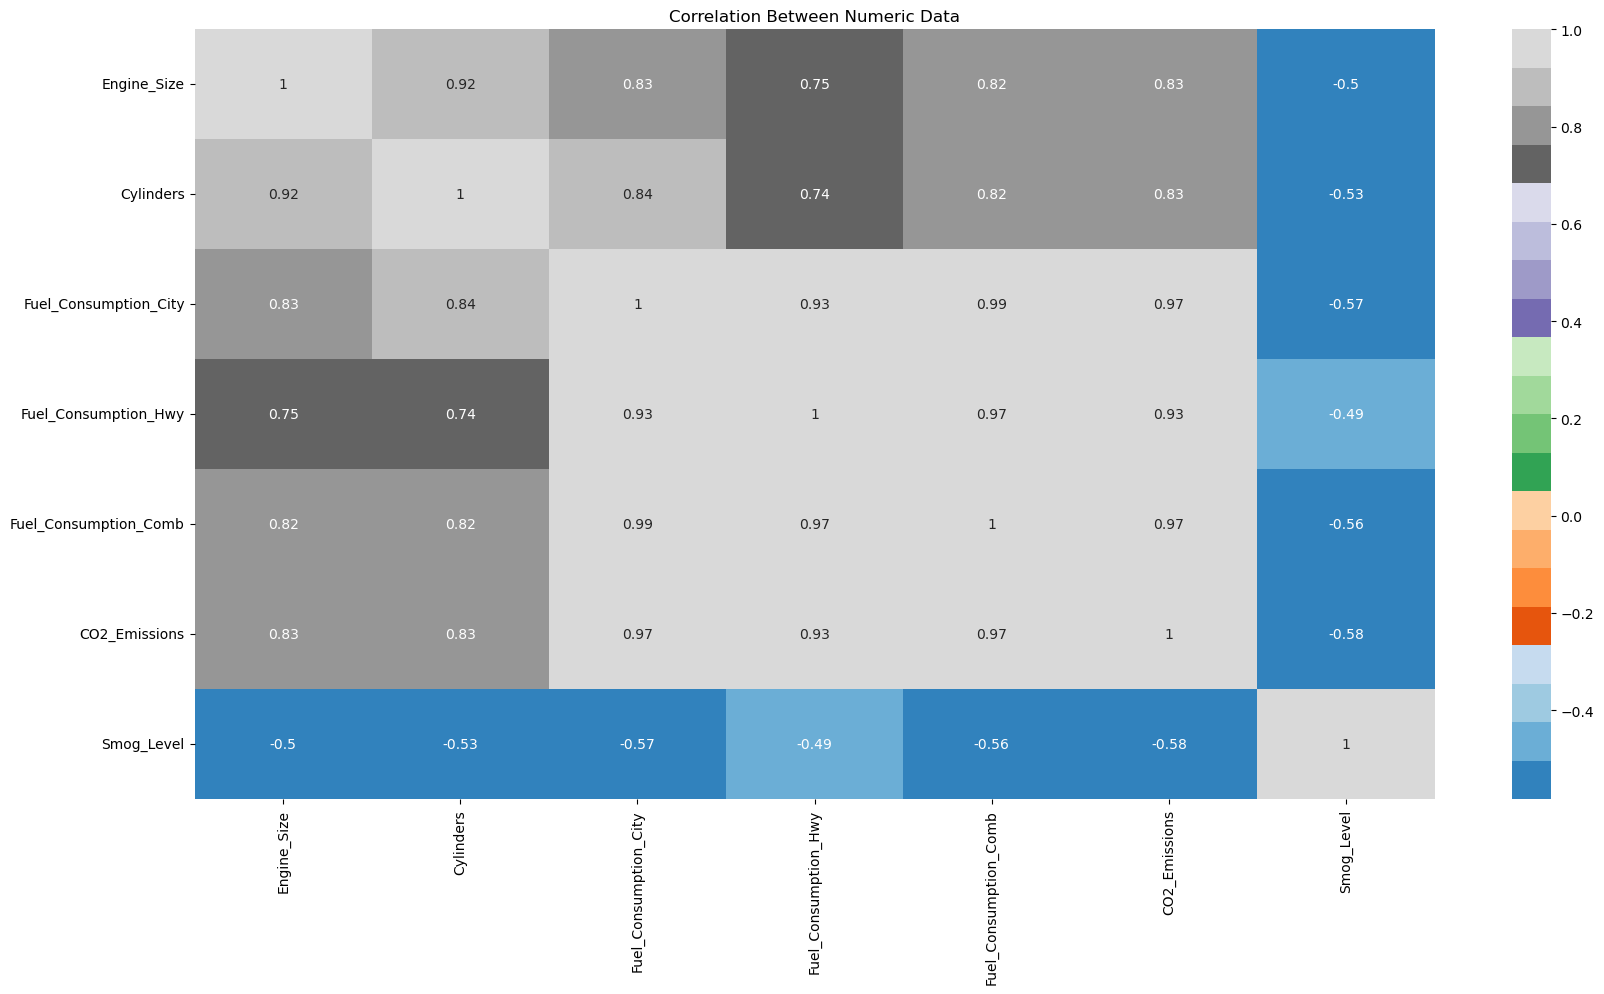

Strong Positive Correlations:
- Fuel consumption metrics (City, Hwy, Comb) are strongly correlated with each other.
- CO2 emissions are strongly correlated with all fuel consumption metrics.

Moderate Positive Correlations:
- Engine size and cylinders show moderate correlation with fuel consumption and CO2 emissions.
- Smog level is moderately correlated with CO2 emissions and fuel consumption metrics.



In [6]:
#Correlation

corr_data = data.drop("Model_Year", axis=1)
data_num_features = corr_data.select_dtypes(include=np.number)

plt.figure(figsize=(20,10))

corr = data_num_features.corr()

#Correlation for numeric data
corr =data_num_features.corr(method='pearson')
sns.heatmap(corr, annot=True,cmap='tab20c')
plt.title("Correlation Between Numeric Data")
plt.xticks(rotation=90)
plt.show()

print("Strong Positive Correlations:")
print("- Fuel consumption metrics (City, Hwy, Comb) are strongly correlated with each other.")
print("- CO2 emissions are strongly correlated with all fuel consumption metrics.")

print("\nModerate Positive Correlations:")
print("- Engine size and cylinders show moderate correlation with fuel consumption and CO2 emissions.")
print("- Smog level is moderately correlated with CO2 emissions and fuel consumption metrics.")
print()

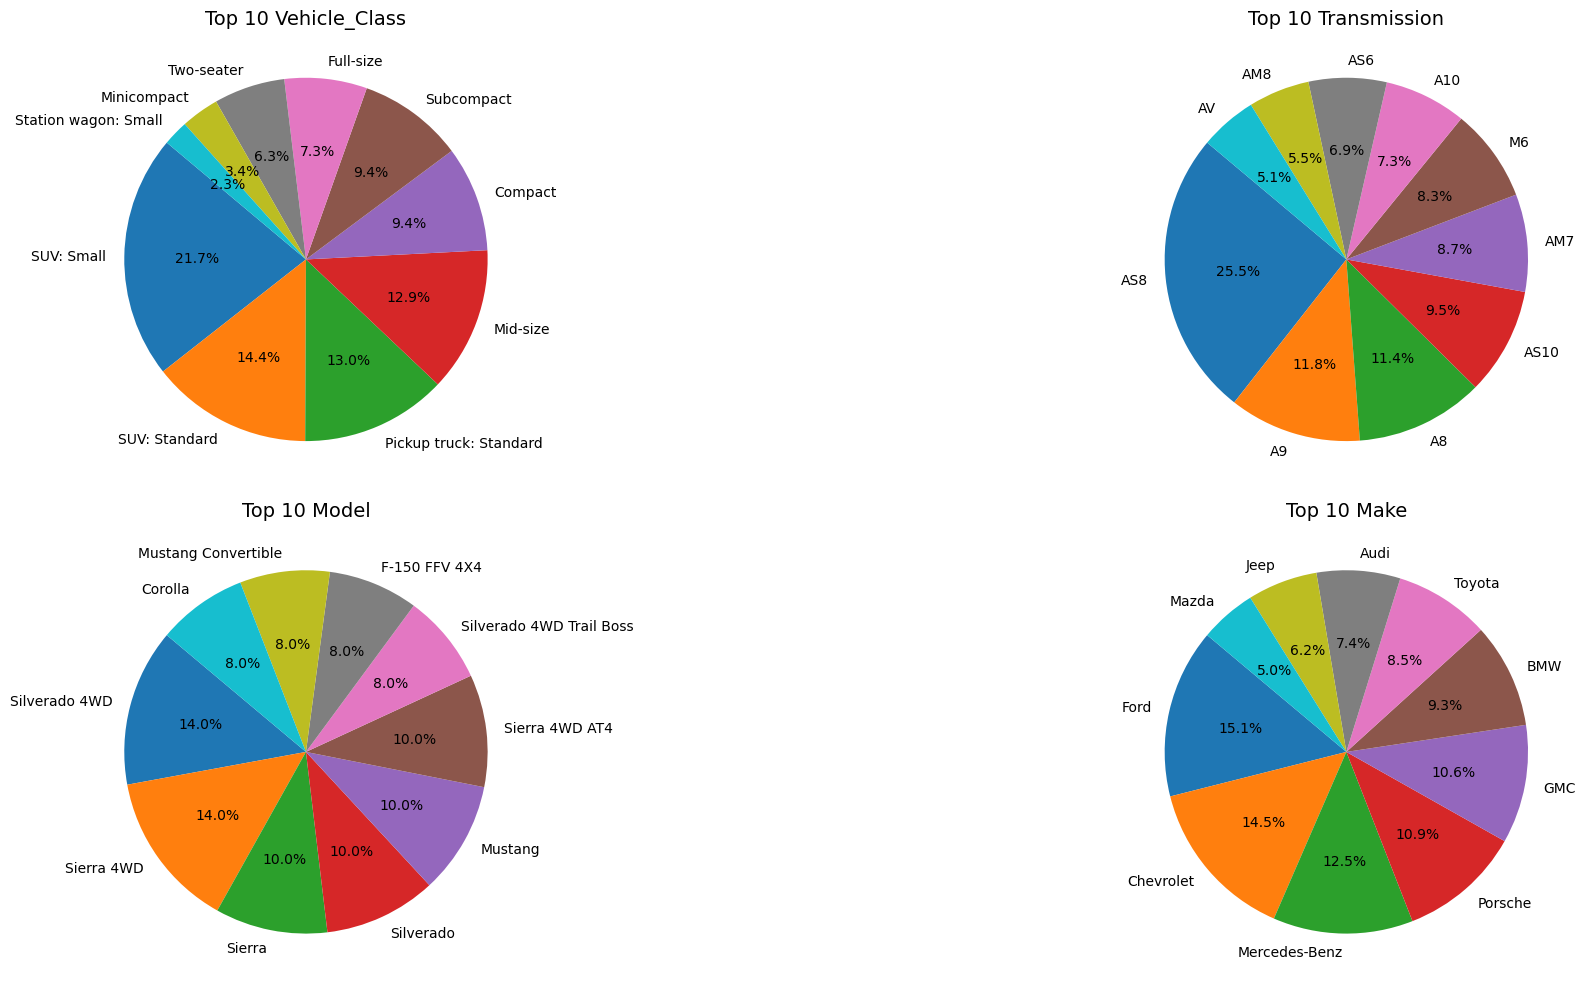

Top 10 Make: Most of the cars on the road are made by Ford
Top 10 Model: The Silverado 4WD is amongst the most famous models driven
Top 10 Vehicle_Class: SUV: Small is the preferred class of vehicle
Top 10 Transmission: More than 1000 cars have AS8 transmission types


In [7]:
#Correlation for categoric data
data_cat_features = data.select_dtypes(include='object')
data_cat_features1 = data_cat_features[['Vehicle_Class', 'Transmission', 'Model', 'Make']]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25, 10))

for variable, subplot in zip(data_cat_features1.columns, ax.flatten()):
    cat_count = data[variable].value_counts()
    cat_count15 = cat_count[:10]

    if cat_count.size > 10:
        title = 'Top 10 {}'.format(variable)
    else:
        title = variable

    subplot.pie(cat_count15.values, labels=cat_count15.index, autopct='%1.1f%%', startangle=140)
    subplot.set_title(title, fontsize=14)

plt.tight_layout()
plt.show()

# Extracting top 10 categories for the specified categorical variables
top_10_make = data['Make'].value_counts().head(10)
top_10_model = data['Model'].value_counts().head(10)
top_10_vehicle_class = data['Vehicle_Class'].value_counts().head(10)
top_10_transmission = data['Transmission'].value_counts().head(10)

print(f"Top 10 Make: Most of the cars on the road are made by {top_10_make.idxmax()}")
print(f"Top 10 Model: The {top_10_model.idxmax()} is amongst the most famous models driven")
print(f"Top 10 Vehicle_Class: {top_10_vehicle_class.idxmax()} is the preferred class of vehicle")
print(f"Top 10 Transmission: More than 1000 cars have {top_10_transmission.idxmax()} transmission types")



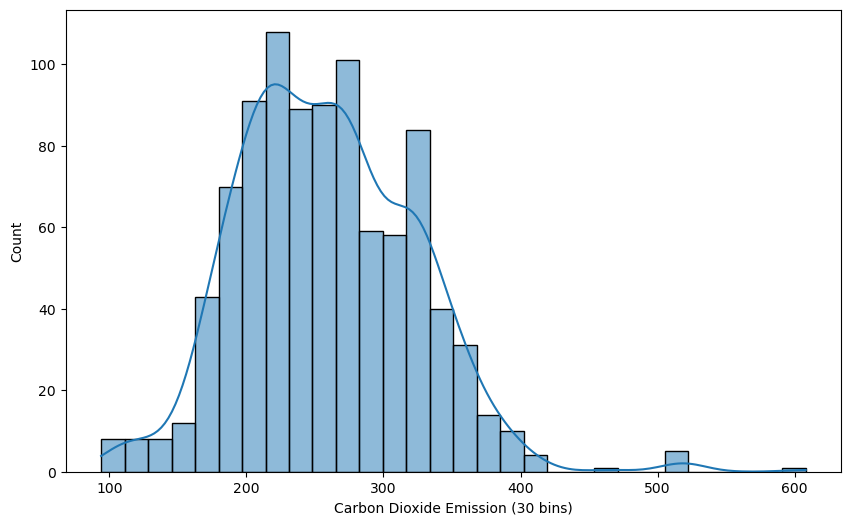

In [8]:
#Analyzing Target Variable

plt.figure(figsize=(10, 6))
sns.histplot(data['CO2_Emissions'], bins=30, kde=True)
plt.xlabel('Carbon Dioxide Emission (30 bins)')

plt.show()

Mean for CO2 Emission is 258.52941176470586
Median for CO2 Emission is 255.0
Mode for CO2 Emission is 214


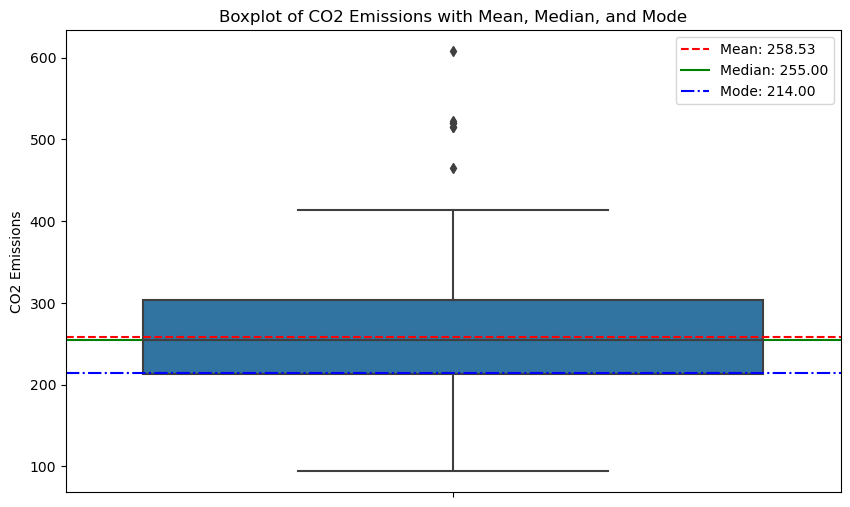

Of all the three statistics, the mean is the largest, while the mode is the smallest thus CO2_Emissions is positively skewed which implies that most of the CO2 Emissions are less than the average CO2 Emissions.


In [9]:
#Getting mean, median, and mode of CO2 Emissions and plotting on Boxplot
mean = data['CO2_Emissions'].mean()
mode = data['CO2_Emissions'].mode()[0]
median = data['CO2_Emissions'].median()

print(f'Mean for CO2 Emission is {mean}')
print(f'Median for CO2 Emission is {median}')
print(f'Mode for CO2 Emission is {mode}')

fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(y=data['CO2_Emissions'], ax=ax)

ax.axhline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
ax.axhline(median, color='g', linestyle='-', label=f'Median: {median:.2f}')
ax.axhline(mode, color='b', linestyle='-.', label=f'Mode: {mode:.2f}')

ax.legend()

ax.set_ylabel('CO2 Emissions')
ax.set_title('Boxplot of CO2 Emissions with Mean, Median, and Mode')

plt.show()

#Analysis of Centers of CO2 Emissions
print("Of all the three statistics, the mean is the largest, "
      "while the mode is the smallest thus CO2_Emissions is positively "
      "skewed which implies that most of the CO2 Emissions are less than "
      "the average CO2 Emissions.")

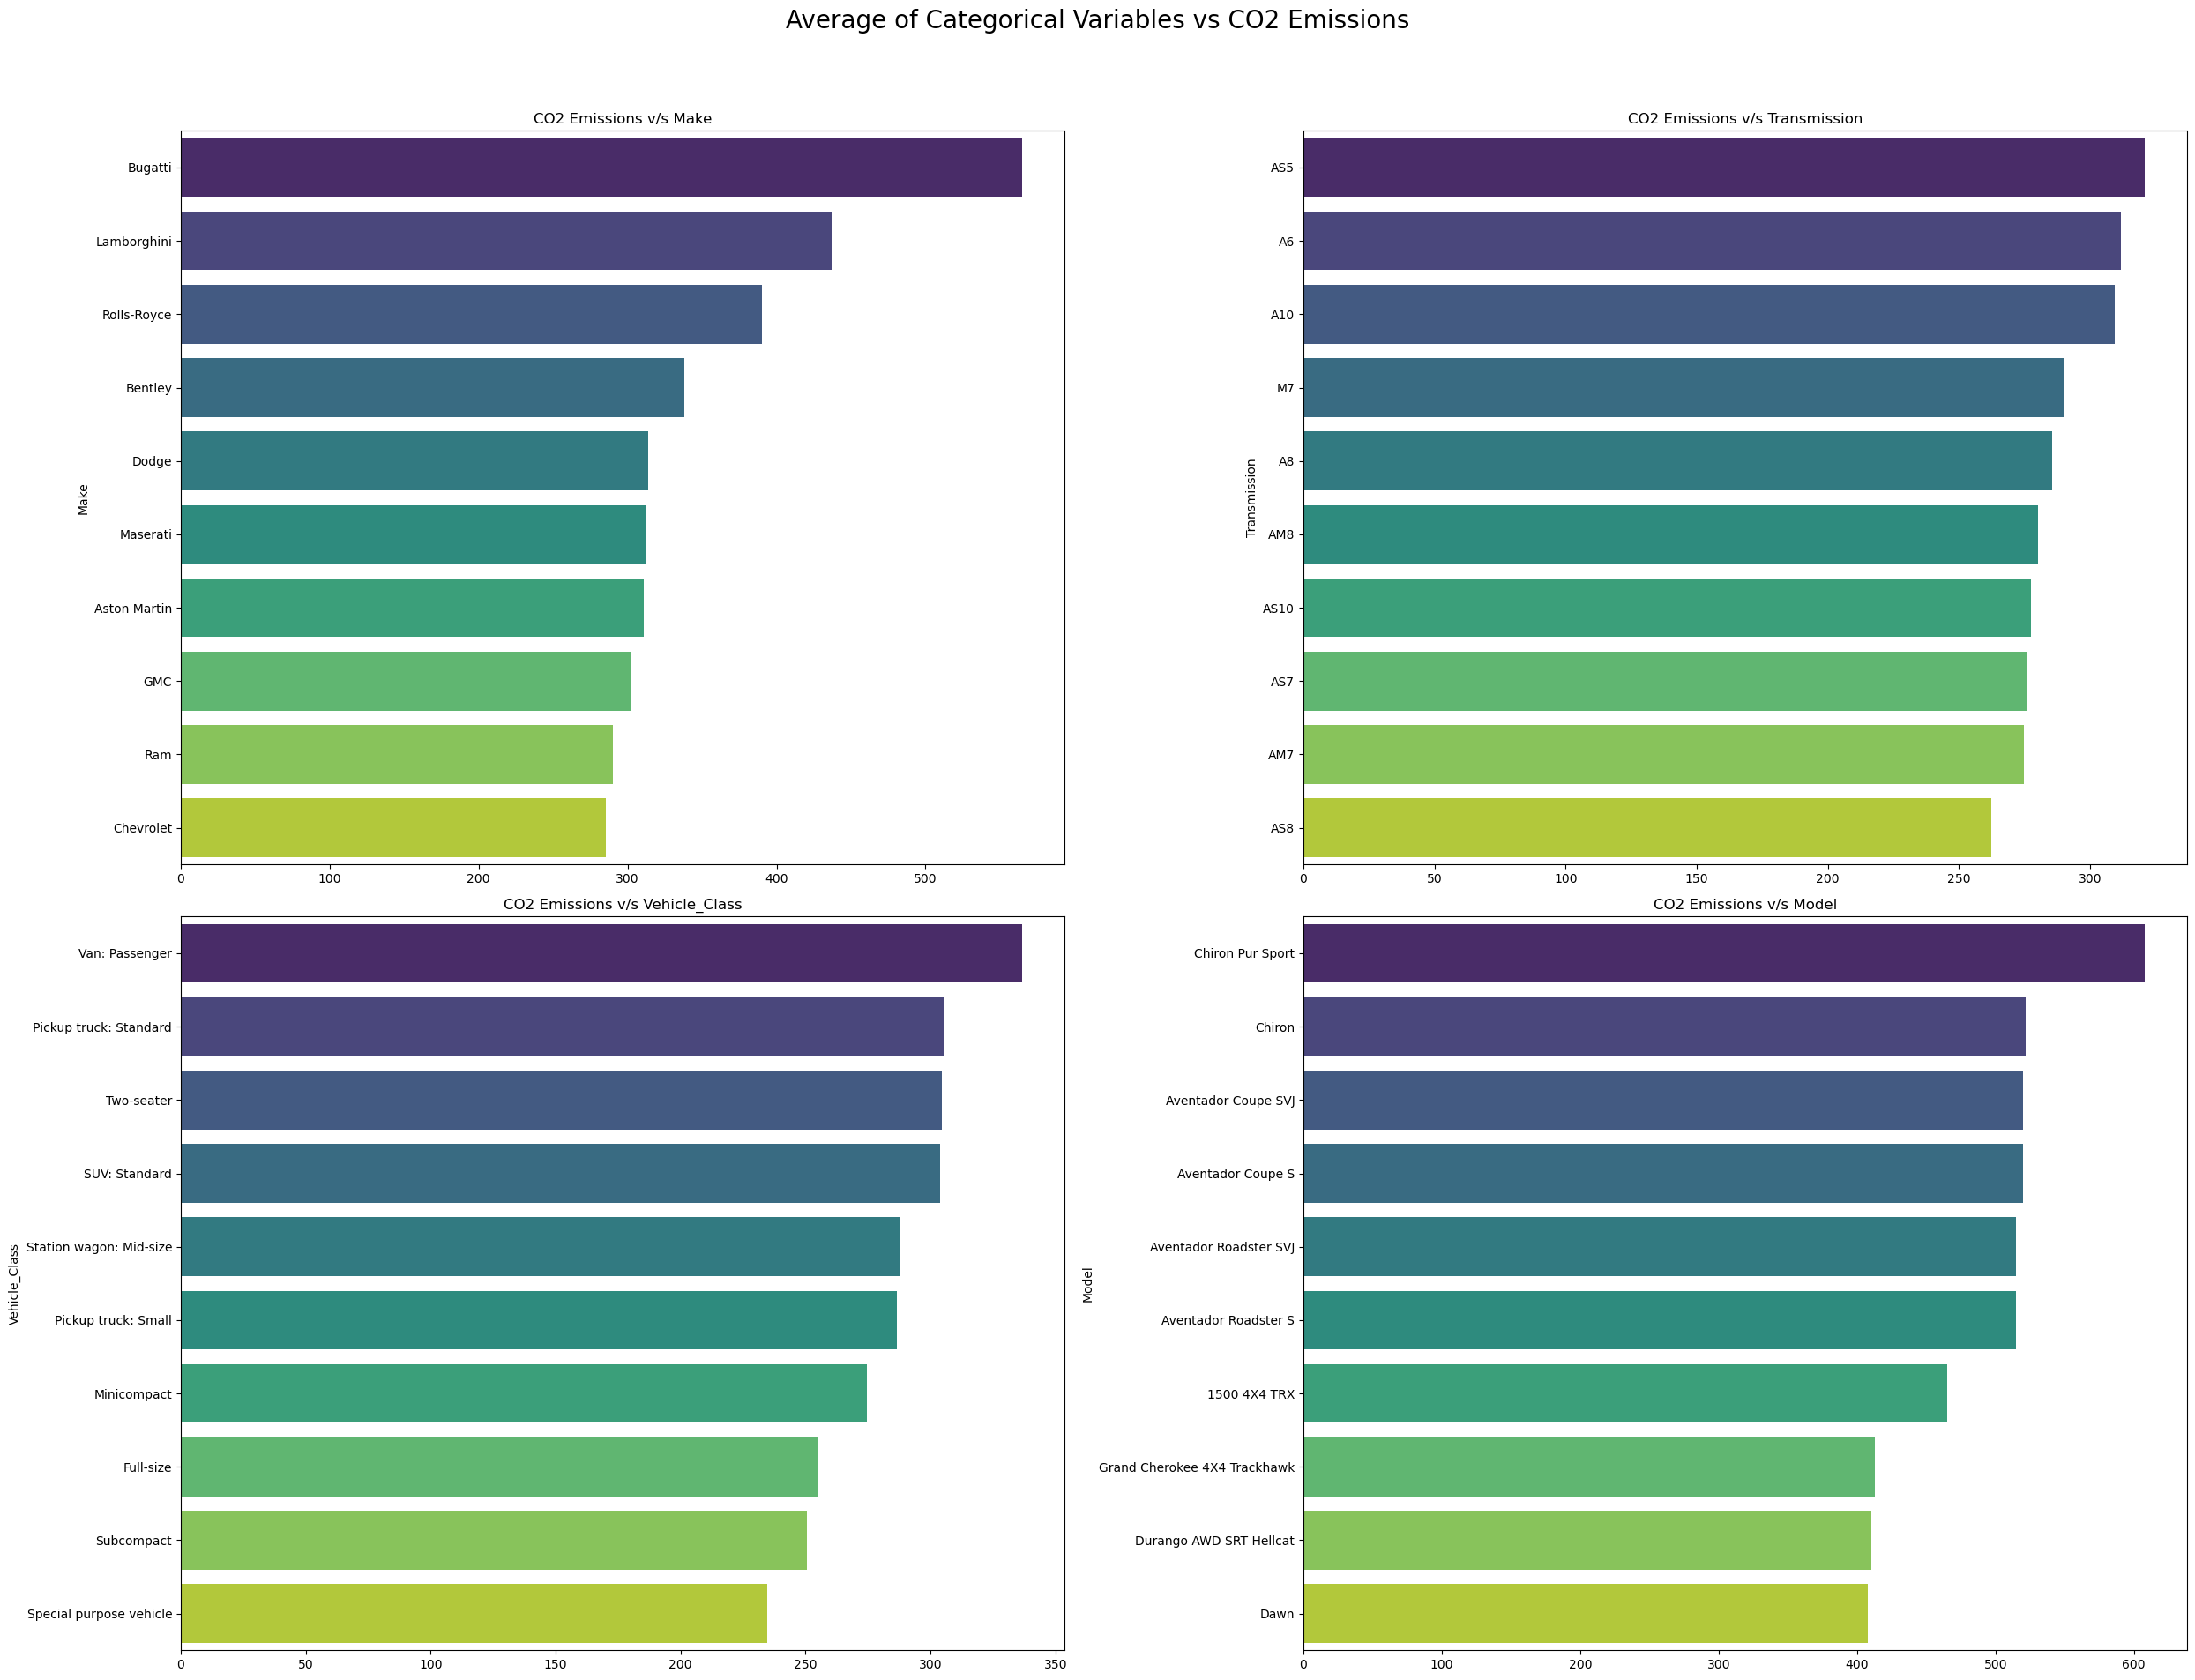

CO2 Emissions v/s Make: While Ford cars are mainly found on the roads, it is Bugatti that emits the most CO2 per car.
CO2 Emissions v/s Model: Chiron Pur Sport is amongst the most CO2 emitting car model.
CO2 Emissions v/s Vehicle_Class: Most of the heavy vehicles like Vans, SUV, and Pick-up trucks are amongst the top few emitters of CO2.
CO2 Emissions v/s Transmission: Most of the cars with AS5 transmission emit CO2.



In [10]:
#Analyzing the relationship between target variable and features
# Grouping and sorting data
make_co2 = data.groupby('Make')['CO2_Emissions'].mean().sort_values(ascending=False).head(10)
model_co2 = data.groupby('Model')['CO2_Emissions'].mean().sort_values(ascending=False).head(10)
vehicle_class_co2 = data.groupby('Vehicle_Class')['CO2_Emissions'].mean().sort_values(ascending=False).head(10)
transmission_co2 = data.groupby('Transmission')['CO2_Emissions'].mean().sort_values(ascending=False).head(10)
palette = sns.color_palette("viridis", 10)

# Creating subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 20))
fig.suptitle('Average of Categorical Variables vs CO2 Emissions', size=20)

# Plotting CO2 Emissions v/s Make
sns.barplot(ax=axes[0][0], x=make_co2.values, y=make_co2.index, hue=make_co2.index, palette=palette, dodge=False)
legend = axes[0][0].get_legend()
if legend:
    legend.remove()
axes[0][0].set_title('CO2 Emissions v/s Make')

# Plotting CO2 Emissions v/s Transmission
sns.barplot(ax=axes[0][1], x=transmission_co2.values, y=transmission_co2.index, hue=transmission_co2.index, palette=palette, dodge=False)
legend = axes[0][1].get_legend()
if legend:
    legend.remove()
axes[0][1].set_title('CO2 Emissions v/s Transmission')

# Plotting CO2 Emissions v/s Vehicle_Class
sns.barplot(ax=axes[1][0], x=vehicle_class_co2.values, y=vehicle_class_co2.index, hue=vehicle_class_co2.index, palette=palette, dodge=False)
legend = axes[1][0].get_legend()
if legend:
    legend.remove()
axes[1][0].set_title('CO2 Emissions v/s Vehicle_Class')

# Plotting CO2 Emissions v/s Model
sns.barplot(ax=axes[1][1], x=model_co2.values, y=model_co2.index, hue=model_co2.index, palette=palette, dodge=False)
legend = axes[1][1].get_legend()
if legend:
    legend.remove()
axes[1][1].set_title('CO2 Emissions v/s Model')

# Adjusting layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Identifying top categories
top_make = make_co2.idxmax()
top_model = model_co2.idxmax()
top_vehicle_class = vehicle_class_co2.idxmax()
top_transmission = transmission_co2.idxmax()

print(f"CO2 Emissions v/s Make: While Ford cars are mainly found on the roads, it is {top_make} that emits the most CO2 per car.")
print(f"CO2 Emissions v/s Model: {top_model} is amongst the most CO2 emitting car model.")
print(f"CO2 Emissions v/s Vehicle_Class: Most of the heavy vehicles like Vans, SUV, and Pick-up trucks are amongst the top few emitters of CO2.")
print(f"CO2 Emissions v/s Transmission: Most of the cars with {top_transmission} transmission emit CO2.")
print()

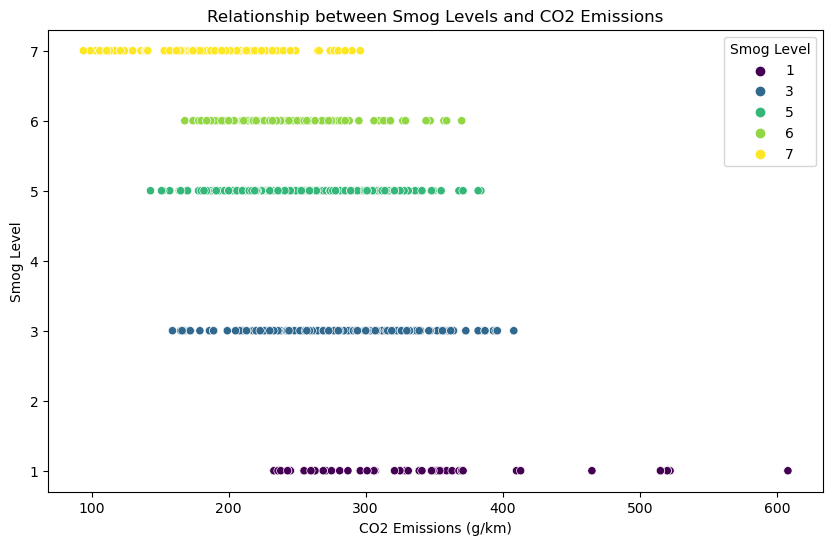

The scatter plot shows the relationship between CO2 emissions and smog levels.
Based on the data, there is a correlation of -0.58 between CO2 emissions and smog levels.
This indicates a moderate negative correlation between CO2 emissions and smog levels.
As CO2 emissions increase, the smog level tends to decrease, indicating that higher CO2 emissions are associated with lower smog levels.
A lower smog level (1) is the most harmful, and smog levels get progressively less harmful as they increase.



In [11]:
#Analyzing the relationship between smog levels and CO2 emissions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='CO2_Emissions', y='Smog_Level', hue='Smog_Level', palette='viridis')
plt.title('Relationship between Smog Levels and CO2 Emissions')
plt.xlabel('CO2 Emissions (g/km)')
plt.ylabel('Smog Level')
plt.legend(title='Smog Level')
plt.show()

correlation = data[['CO2_Emissions', 'Smog_Level']].corr().loc['CO2_Emissions', 'Smog_Level']
print(f"The scatter plot shows the relationship between CO2 emissions and smog levels.")
print(f"Based on the data, there is a correlation of {correlation:.2f} between CO2 emissions and smog levels.")
print(f"This indicates a {'strong' if abs(correlation) > 0.7 else 'moderate' if abs(correlation) > 0.5 else 'weak'} negative correlation between CO2 emissions and smog levels.")
print("As CO2 emissions increase, the smog level tends to decrease, indicating that higher CO2 emissions are associated with lower smog levels.")
print("A lower smog level (1) is the most harmful, and smog levels get progressively less harmful as they increase.")
print()

In [12]:
#Preprocessing

#Identifying outliers

numeric_features = ['Engine_Size', 'Cylinders', 'Fuel_Consumption_City', 'Fuel_Consumption_Hwy', 'Fuel_Consumption_Comb', 'Smog_Level']

# Calculate Q1 and Q3 for numeric features
Q1 = data[numeric_features].quantile(0.25)
Q3 = data[numeric_features].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

# Identify outliers
outliers = (data[numeric_features] < (Q1 - 1.5 * IQR)) | (data[numeric_features] > (Q3 + 1.5 * IQR))

for column in outliers.columns:
    total_outliers = outliers[column].sum()
    print(f'Total number of outliers in column {column} are {total_outliers}')

data = data[~outliers.any(axis=1)]


Engine_Size              2.0
Cylinders                4.0
Fuel_Consumption_City    4.7
Fuel_Consumption_Hwy     3.1
Fuel_Consumption_Comb    4.0
Smog_Level               3.0
dtype: float64
Total number of outliers in column Engine_Size are 2
Total number of outliers in column Cylinders are 2
Total number of outliers in column Fuel_Consumption_City are 10
Total number of outliers in column Fuel_Consumption_Hwy are 14
Total number of outliers in column Fuel_Consumption_Comb are 11
Total number of outliers in column Smog_Level are 0


In [13]:
# Encoding the categorical data
df_dummies = pd.get_dummies(data=data[["Transmission", "Make", "Vehicle_Class", "Model"]], drop_first=True)
df_num_features = data.select_dtypes(include=np.number)
df_comb = pd.concat([df_num_features, df_dummies], axis=1)

Engine_Size: Not a Normal Distribution
Cylinders: Not a Normal Distribution
Fuel_Consumption_City: Not a Normal Distribution
Fuel_Consumption_Hwy: Not a Normal Distribution
Fuel_Consumption_Comb: Not a Normal Distribution
CO2_Emissions: Not a Normal Distribution
Smog_Level: Not a Normal Distribution


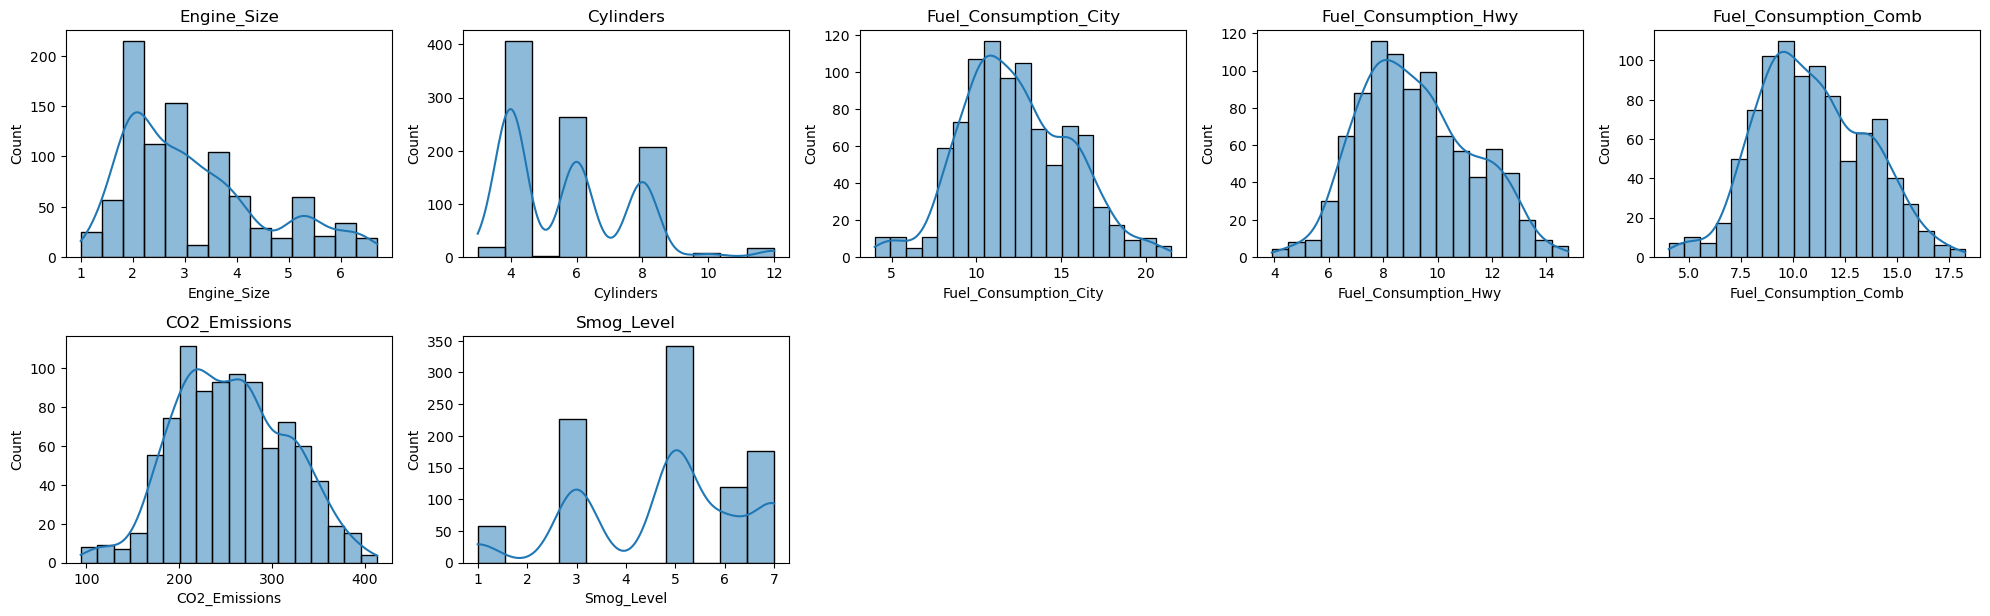

In [14]:
# Function to check normality using the Shapiro-Wilk test
def check_normality(feature):
    stat, p = shapiro(feature)
    return p > 0.05  # If p > 0.05, the distribution is likely normal

numerical_features = df_num_features.drop("Model_Year", axis=1).columns

normality_results = {feature: check_normality(df_num_features[feature]) for feature in numerical_features}

for feature, is_normal in normality_results.items():
    print(f'{feature}: {"Normal Distribution" if is_normal else "Not a Normal Distribution"}')

def visualize_distributions(features, df):
    plt.figure(figsize=(20, 15))
    for i, feature in enumerate(features, 1):
        plt.subplot(5, 5, i)
        sns.histplot(df[feature], kde=True)
        plt.title(f'{feature}')
    plt.tight_layout()
    plt.show()

num_groups = len(numerical_features) // 25 + 1
for i in range(num_groups):
    start = i * 25
    end = (i + 1) * 25
    visualize_distributions(numerical_features[start:end], df_num_features)

# Since none of the features follow a normal distribution, normalization might be a more appropriate scaling technique for this dataset

In [15]:
# Normalizing the dataset
scaler = MinMaxScaler()
df_comb_normalized = scaler.fit_transform(df_comb)
df_comb_normalized = pd.DataFrame(df_comb_normalized, columns=df_comb.columns)

In [16]:
X = df_comb_normalized.drop(columns=["CO2_Emissions"])
y = df_comb_normalized["CO2_Emissions"]

# Saving feature names
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')
print("Feature names saved as feature_names.pkl")

Feature names saved as feature_names.pkl


In [17]:
def adj_r2_score(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Define the models and their parameter grids
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge Regression': {
        'model': Ridge(),
        'params': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Lasso Regression': {
        'model': Lasso(),
        'params': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Decision Tree Regression': {
        'model': DecisionTreeRegressor(),
        'params': {'max_depth': [5, 10, 15, 20, 25]}
    },
    'Random Forest Regression': {
        'model': RandomForestRegressor(),
        'params': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, 20]}
    },
    'Gradient Boosting Regression': {
        'model': GradientBoostingRegressor(),
        'params': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
    }
}

In [19]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# Perform GridSearchCV for each model using KFold
best_models = {}
for model_name, config in models.items():
    print(f"Training {model_name}...")
    grid = GridSearchCV(config['model'], config['params'], cv=kf, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[model_name] = grid.best_estimator_
    print(f"Best parameters for {model_name}: {grid.best_params_}")
    print(f"Best R-squared score for {model_name}: {grid.best_score_}")

cols = ['Model_Name', 'R-squared', 'Adj. R-squared', 'MSE', 'RMSE', 'MAE', 'MAPE']
result_table = pd.DataFrame(columns=cols)

results = []

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = adj_r2_score(r2, X_test.shape[0], X_test.shape[1])
    mse = mean_squared_error(y_test, y_pred)
    rmse_val = rmse(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape_val = mape(y_test, y_pred)

    model_metrics = {'Model_Name': model_name,
                     'R-squared': r2,
                     'Adj. R-squared': adj_r2,
                     'MSE': mse,
                     'RMSE': rmse_val,
                     'MAE': mae,
                     'MAPE': mape_val}

    results.append(model_metrics)

result_table = pd.DataFrame(results, columns=cols)

print(result_table)

best_model_name = result_table.loc[result_table['R-squared'].idxmax(), 'Model_Name']
best_model = best_models[best_model_name]

print(f"\nBest performing model: {best_model_name}")
print(f"Best model: {best_model}")

# Save the best model to a file
joblib.dump(best_model, 'model.pkl')
print("Model saved as model.pkl")

Training Linear Regression...
Best parameters for Linear Regression: {}
Best R-squared score for Linear Regression: -3.0756065820271482e+25
Training Ridge Regression...
Best parameters for Ridge Regression: {'alpha': 1}
Best R-squared score for Ridge Regression: 0.9712929189941364
Training Lasso Regression...
Best parameters for Lasso Regression: {'alpha': 0.01}
Best R-squared score for Lasso Regression: 0.88293950041309
Training Decision Tree Regression...
Best parameters for Decision Tree Regression: {'max_depth': 20}
Best R-squared score for Decision Tree Regression: 0.9625171659056972
Training Random Forest Regression...
Best parameters for Random Forest Regression: {'max_depth': 15, 'n_estimators': 50}
Best R-squared score for Random Forest Regression: 0.9734512561450798
Training Gradient Boosting Regression...
Best parameters for Gradient Boosting Regression: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Best R-squared score for Gradient Boosting Regression: 0.97913

In [20]:
# checking the type of the model file
model = joblib.load('model.pkl')
print(type(model))

<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


In [21]:
# Neural Network Model
def create_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

nn_model = create_model()

# Fitting the model
history = nn_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluating the model
nn_pred = nn_model.predict(X_test)
nn_mse = mean_squared_error(y_test, nn_pred)
print(f'Neural Network Test Mean Squared Error: {nn_mse}')

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1929 - val_loss: 0.0241
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0404 - val_loss: 0.0179
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242 - val_loss: 0.0083
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0163 - val_loss: 0.0081
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140 - val_loss: 0.0063
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - val_loss: 0.0074
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - val_loss: 0.0078
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - val_loss: 0.0058
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0064
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0048
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_lo